<center><h1>Ma_Htet_Project</h1></center>
<br>
Name: Htet Ma
<br>
Github Username: hswma 
<br>
USC ID: 4522446617

#### Package imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
import random
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

os.chdir('../Data')

####  Data Exploration and Pre-processing

In [2]:
folder = 'Sport Images'
subdir = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']
batch_size = 5
train_ds = keras.utils.image_dataset_from_directory(folder, labels='inferred', batch_size=batch_size, image_size=(256, 256), 
                                                    shuffle=True, seed=123, validation_split=0.3, subset="training")
val_ds = keras.utils.image_dataset_from_directory(folder, labels='inferred', batch_size=batch_size, image_size=(256, 256),
                                                  shuffle=True, seed=123, validation_split=0.3, subset="validation")

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((1*val_batches) // 2)
val_ds = val_ds.skip((1*val_batches) // 2)

#Ref: https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker

Found 3279 files belonging to 5 classes.
Using 2296 files for training.
Found 3279 files belonging to 5 classes.
Using 983 files for validation.


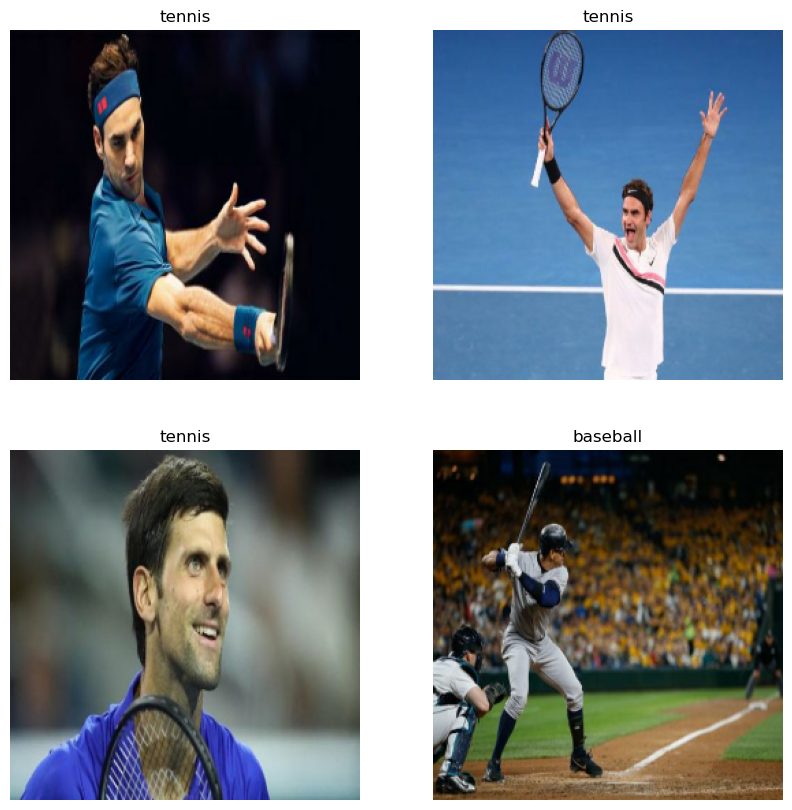

In [3]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Transfer Learning for Image Classification

In [4]:
data_augmentation = keras.Sequential([keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                                      keras.layers.experimental.preprocessing.RandomRotation(0.1),])

In [19]:
from datetime import datetime
os.makedirs('logs', exist_ok=True)
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

In [20]:
def transfer_learning(model, epoch=50, num_classes=5, input_shape=(256, 256, 3), tboard_callback=None):

    if model == 'VGG16':
        from keras.applications.vgg16 import preprocess_input
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model == 'ResNet50':
        from keras.applications.resnet50 import preprocess_input
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model == 'EfficientNetB0':
        from keras.applications.efficientnet import preprocess_input
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError('Invalid model.')
    base_model.trainable = False
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs) 
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=keras.metrics.SparseCategoricalAccuracy())
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    callbacks = [early_stop]
    if tboard_callback is not None:
        callbacks.append(tboard_callback)
    training_history = model.fit(train_ds, epochs=epoch, validation_data=val_ds, callbacks=callbacks)
    acc_epoch = training_history.history

    #test data
    actual = [labels for _, labels in test_ds.unbatch()]
    predicted = model.predict(test_ds).argmax(axis=-1)
    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)

    loss_test, acc_test = model.evaluate(test_ds)

    cm_test = tf.math.confusion_matrix(actual, predicted)

    precision_test = precision_score(actual, predicted, average='weighted')
    recall_test = recall_score(actual, predicted, average='weighted')
    f1_test = f1_score(actual, predicted, average='weighted')

    #train data
    actual = [labels for _, labels in train_ds.unbatch()]
    predicted = model.predict(train_ds).argmax(axis=-1)
    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)

    loss_train, acc_train = model.evaluate(train_ds)

    cm_train = tf.math.confusion_matrix(actual, predicted)

    precision_train = precision_score(actual, predicted, average='weighted')
    recall_train = recall_score(actual, predicted, average='weighted')
    f1_train = f1_score(actual, predicted, average='weighted')
    
    return acc_epoch, acc_test, precision_test, recall_test, f1_test, cm_test, acc_train, precision_train, recall_train, f1_train, cm_train

In [22]:
model_vgg166 = transfer_learning('VGG16', epoch=1, tboard_callback=tboard_callback)


# model_resnet50 = transfer_learning('RestNet50', epoch=50)
# model_efficientnet50 = transfer_learning('EfficientNetB0', epoch=50)

460/460 [==============================] - 609s 1s/step - loss: 0.2030 - sparse_categorical_accuracy: 0.9247


In [ ]:
ax = sns.heatmap(cm, annot=True, fmt='g')
sns.set(rc={'figure.figsize':(12, 12)})
sns.set(font_scale=1.4)
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted Action')
ax.set_ylabel('Actual Action')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

#### Video Classification Using Moving Averages

In [ ]:
meta_ds = keras.utils.image_dataset_from_directory(folder, labels='inferred', batch_size=batch_size, image_size=(256, 256), 
                                                    shuffle=True, seed=123, validation_split=0)

data_augmentation = keras.Sequential([keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                                      keras.layers.experimental.preprocessing.RandomRotation(0.1),])

num_classes = 5

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs) 
x = preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=keras.metrics.SparseCategoricalAccuracy())

history_vgg16 = model.fit(meta_ds,epochs=1)

In [ ]:
L = 100

input_shape = (256, 256)

data_dir = "Sport Videos"
ds = tf.data.Dataset.list_files(data_dir + "/*/*.avi")

In [ ]:
import glob

videofiles = glob.glob(data_dir + '/*/*.avi')

In [ ]:
def get_class(fname):
    """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
    """
    return os.path.basename(os.path.dirname(fname))

In [ ]:
def get_files_per_class(files):
    """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
    """
    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = get_class(fname)
        files_for_class[class_name].append(fname)
    return files_for_class

In [ ]:
def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [ ]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224)):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    
    frame_step = int(video_length / (n_frames - 1))

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
            if ret:
                frame = format_frames(frame, output_size)
                result.append(frame)
            else:
                result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

In [ ]:
n_frames = 100
label_dict = {"BaseballPitch": "baseball", "Basketball": "basketball", "Fencing": "fencing", "TennisSwing": "tennis",
             "VolleyballSpiking": "volleyball"}

predicted = []
actual = []
for each_video in range(5):
    video_path = videofiles[each_video]
    result = frames_from_video_file(video_path, n_frames, output_size = (256,256))
    
    ground_truth = get_class(video_path)
    actual.append(meta_ds.class_names.index(label_dict[ground_truth]))
    
    prob = model.predict(result)
    prob_label = predicted_prob.argmax(axis=-1)
    majority_label = Counter(prob_label).most_common(1)[0][0]
    
    predicted.append(majority_label)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

cm = confusion_matrix(actual, predicted)
ax = sns.heatmap(cm, annot=True, fmt='g')
sns.set(rc={'figure.figsize':(12, 12)})
sns.set(font_scale=1.4)
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted Action')
ax.set_ylabel('Actual Action')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
# ax.xaxis.set_ticklabels(label_dict.keys())
# ax.yaxis.set_ticklabels(label_dict.keys())

accuracy_score = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted, average='weighted')
recall = recall_score(actual, predicted, average='weighted')
f1 = f1_score(actual, predicted, average='weighted')

print(accuracy_score, precision, recall, f1)

In [ ]:
tf.keras.applications.resnet50.preprocess_input